In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

import gpflow
from gpflow.utilities import print_summary, positive

import tensorflow as tf
from tensorflow import math as tfm
from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd
from tensorflow_probability import mcmc

from load_puma_data import load_barenco_puma
import math
import random

PI = tf.constant(math.pi, dtype='float64')
plt.style.use('ggplot')
%matplotlib inline

In [2]:
df, genes, genes_se, Y, Y_var = load_barenco_puma()


N_m = 7               # Number of observations
def calc_N_p(N_p, num_disc=8):
    '''A helper recursive function to ensure t is a subset of τ'''
    if num_disc <= 0:
        return N_p
    return N_p -1 + calc_N_p(N_p, num_disc-1)
num_disc = 10
N_p = calc_N_p(N_m, num_disc)  # Number of time discretisations
common_indices = np.array([i*num_disc+i for i in range(N_m)])
t = np.arange(N_m)*2           # Observation times
τ = np.linspace(0, 12, N_p, dtype='float32')    # Discretised observation times
num_genes = 5
I = 1 # Number of TFs

m_observed = np.float32(Y[:-1])
f_observed = np.float32(np.atleast_2d(Y[-1]))
σ2 = np.float32(Y_var[:-1])
σ2_f = np.float32(np.atleast_2d(Y_var[-1]))

## Metropolis Hastings Custom MCMC Algorithm

In [161]:
# Parameters
params = None
w_j0 = 1    # Interaction bias (TODO)
fbar_i = 0.5*np.ones(N_p, dtype='float32')
v_i = 1 # Fix this to 1 if translation model is not used (pg.8)
l2_i = 0.1
δbar_i = np.float32(1)
h_δ = 1
h_c = 0.3
h_f = 0.4*tf.ones(N_p, dtype='float32')
h_k = 0.1*tf.ones(4, dtype='float32')
h_w = tf.ones(num_genes, dtype='float32')
h_σm = tf.constant(0.8, dtype='float32')
a = tf.constant(-0.5, dtype='float32')
b2 = tf.constant(2., dtype='float32')
w_j = 0.5*np.ones((num_genes, I))
σ_m2 = 1e-2*np.ones(num_genes, dtype='float32')
kbar_i = 0.1*np.float32(np.c_[np.ones(num_genes), # a_j
                          np.ones(num_genes), # b_j
                          np.ones(num_genes), # d_j
                          np.ones(num_genes)])# s_j
def fixed(kbar, gene):
    if gene == 3:
        kbar[2] = np.log(0.8)
        kbar[3] = np.log(1.0)
    kbar[kbar < -10] = -10
    kbar[kbar > 2] = 2
    return kbar
kbar_i[3] = fixed(kbar_i[3], 3)


In [162]:
print(kbar_i)

[[0.10000 0.10000 0.10000 0.10000]
 [0.10000 0.10000 0.10000 0.10000]
 [0.10000 0.10000 0.10000 0.10000]
 [0.10000 0.10000 -0.22314 0.00000]
 [0.10000 0.10000 0.10000 0.10000]]


In [223]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

def get_rbf_dist(times, N):
    t_1 = np.reshape(np.tile(times, N), [N, N]).T
    t_2 = np.reshape(np.tile(times, N), [N, N])
    return t_1-t_2

# Priors
def l2_prior(l2):
    return tfd.InverseGamma(0.1, 0.1).log_prob(l2) # TODO
def v_prior(v):
    return tfd.InverseGamma(0.1, 0.1).log_prob(v)
def σ_m2_prior(σ):
    return tfd.InverseGamma(0.01, 0.01).log_prob(σ)

def w_j_prior(w_j): # At the moment this is the same as w_j0 (see pg.8)
    return tfd.Normal(0, 2).log_prob(w_j0)
def w_j0_prior(w_j0):
    return tfd.Normal(0, 2).log_prob(w_j0)
    
def kbar_prior(kbar):
    return np.prod(tfd.Normal(a, b2).log_prob(kbar))

def fbar_prior_params(v=v_i, l2=l2_i):
    t_dist = get_rbf_dist(τ, N_p)
#     print('vl2', v, l2)
    jitter = tf.linalg.diag(1e-5 * np.ones(N_p, dtype='float32'))
    K = v * np.exp(-np.square(t_dist)/(2*l2)) + jitter
#     print(K)
    m = np.zeros(N_p, dtype='float32')
    return m, K

def fbar_prior(fbar, v=v_i, l2=l2_i):
    m, K = fbar_prior_params(v, l2)
    try:
        prob = np.float64(tfd.MultivariateNormalFullCovariance(m, K).prob(fbar))
        return prob
    except:
        jitter = tf.linalg.diag(1e-4 * np.ones(N_p, dtype='float32'))
        try:
            prob = np.float64(tfd.MultivariateNormalFullCovariance(m, K+jitter).log_prob(fbar))
            return prob
        except:
            return 0

def δbar_prior(δ):
    return np.float64(tfd.Normal(a, b2).log_prob(δ))

# Likelihoods
def G(k, n, p_i, d_j, w):
    '''TF Activation Function'''
    # TODO add binary vector x_j for prior network knowledge (pg.3)
    numerator = np.exp(-d_j*(τ[n]-τ[k]))
    denominator = (1+np.exp(-w_j0-sum([w[:,i]*np.log(p_i[k]) for i in range(I)])))
    return numerator/denominator

def predict_m(kbar, δbar, w, fbar):
    # Take relevant parameters out of log-space
    a_j, b_j, d_j, s_j = (np.exp(kbar[:, i]) for i in range(4)) 
    δ = np.exp(δbar)
    f_i = np.log(1+np.exp(fbar))
    print('f_i', f_i)
    # Define p_i vector
    p_i = np.zeros(N_p)
    for n in range(N_p): # TODO it seems the ODE translation model has params A, S see gpmtfComputeTFODE
        N_pn = n#n*10+n
        p_i[n] = np.trapz([f_i[k] * np.exp(-δ*(τ[n]-τ[k])) for k in range(N_pn)], τ[:N_pn])
    print('pi', p_i)

    # Calculate m_pred
    m_pred = np.zeros((num_genes, N_p), dtype='float32')

    for n in range(N_p):
        N_pn = n#*10+n
        ys =  np.array([G(k, n, p_i, d_j, w) for k in range(N_pn)])
        if ys.shape[0] == 0:
            ys = np.zeros((0, num_genes))
        integrals = np.array([np.trapz(ys[:, i], τ[:N_pn]) for i in range(num_genes)])
#         print('integrals', integrals)
#         print( np.exp(-d_j*t[n]))
        m_pred[:, n] = b_j/d_j + (a_j-b_j/d_j)* np.exp(-d_j*τ[n]) + s_j*integrals
    return m_pred

def m_likelihood(δbar=δbar_i, 
                 fbar=fbar_i, 
                 kbar=kbar_i, 
                 w=w_j,
                 σ_m2=σ_m2,
                 changed=True):
#     if changed is False or (
#         old_m_likelihood is not None and 
#         δbar == δbar_i and 
#         np.array_equal(fbar, fbar_i) and 
#         np.array_equal(kbar, kbar_i) and 
#         np.array_equal(w, w_j) and 
#         np.array_equal(σ_m2, σ_m2)):
#         return old_m_likelihood
    
    m_pred = predict_m(kbar, δbar, w, fbar)
    lik = np.zeros(num_genes)
    diff = m_observed - m_pred[:, common_indices]
    t_dist = get_rbf_dist(t, N_m)        # RBF covariance
    jitter = tf.linalg.diag(1e-5 * np.ones(N_m, dtype='float32'))
    K = 1 * np.exp(-np.square(t_dist)/(2*1)) + jitter # TODO replace v, l2
    for j in range(num_genes):
        K_j = K + tf.linalg.diag(σ2[j])
#         print(K_j)
        L = tf.linalg.cholesky(K_j)
        d = diff[j][:, None]
        alpha = tf.linalg.triangular_solve(L, d, lower=True)
        num_dims = tf.cast(tf.shape(d)[0], L.dtype)
        p = -0.5 * tf.reduce_sum(tf.square(alpha), 0)
        p -= 0.5 * num_dims * np.log(2 * np.pi)
        p -= tf.reduce_sum(tf.math.log(tf.linalg.diag_part(L)))
        lik[j] = p
    return lik

def f_likelihood(fbar, i=0): 
    '''TODO this should be for the i-th TF'''
    f_i = np.log(1+np.exp(fbar))
    f_i = np.float32(np.atleast_2d(f_i[common_indices]))
#     print(f_i[i], f[i])
    prob = tfd.Normal(f_observed[i], σ2_f[i]).log_prob(f_i[i])
#     print('prob', prob)
    lik = tf.reduce_sum(prob)
    return lik

old_m_likelihood = None
old_m_likelihood = m_likelihood(changed=True)
print(old_m_likelihood)

f_i [22.50000 22.50000 22.50000 22.50000 22.50000 22.50000 22.50000 22.50000
 22.50000 22.50000 22.50000 22.50000 22.50000 22.50000 22.50000 22.50000
 22.50000 22.50000 22.50000 22.50000 22.50000 22.50000 22.50000 22.50000
 22.50000 22.50000 22.50000 22.50000 22.50000 22.50000 22.50000 22.50000
 22.50000 22.50000 22.50000 22.50000 22.50000 22.50000 22.50000 22.50000
 22.50000 22.50000 22.50000 22.50000 22.50000 22.50000 22.50000 22.50000
 22.50000 22.50000 22.50000 22.50000 22.50000 22.50000 22.50000 22.50000
 22.50000 22.50000 22.50000 22.50000 22.50000 22.50000 22.50000 22.50000
 22.50000 22.50000 22.50000]
pi [0.00000 0.00000 2.00902 3.23459 3.98224 4.43834 4.71657 4.88631 4.98985
 5.05302 5.09155 5.11506 5.12940 5.13815 5.14348 5.14674 5.14873 5.14994
 5.15068 5.15113 5.15140 5.15157 5.15167 5.15174 5.15177 5.15180 5.15181
 5.15182 5.15183 5.15182 5.15183 5.15183 5.15183 5.15183 5.15184 5.15183
 5.15184 5.15184 5.15183 5.15184 5.15183 5.15184 5.15184 5.15183 5.15184
 5.15184 5.1518

c:\users\jacob\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log


In [225]:
fbar = np.zeros(N_p)
fbar[common_indices] = np.log(np.exp(f_observed)-1)

fbar_i+=0.5
print('-------')
print(m_likelihood())
print('------')
print(m_likelihood(fbar=fbar))


[[2.03108 2.55676 3.81072 1.68575 1.68835 0.90793 0.54854]]
-------
f_i [23.50000 23.50000 23.50000 23.50000 23.50000 23.50000 23.50000 23.50000
 23.50000 23.50000 23.50000 23.50000 23.50000 23.50000 23.50000 23.50000
 23.50000 23.50000 23.50000 23.50000 23.50000 23.50000 23.50000 23.50000
 23.50000 23.50000 23.50000 23.50000 23.50000 23.50000 23.50000 23.50000
 23.50000 23.50000 23.50000 23.50000 23.50000 23.50000 23.50000 23.50000
 23.50000 23.50000 23.50000 23.50000 23.50000 23.50000 23.50000 23.50000
 23.50000 23.50000 23.50000 23.50000 23.50000 23.50000 23.50000 23.50000
 23.50000 23.50000 23.50000 23.50000 23.50000 23.50000 23.50000 23.50000
 23.50000 23.50000 23.50000]
pi [0.00000 0.00000 2.09831 3.37835 4.15923 4.63560 4.92620 5.10348 5.21162
 5.27760 5.31784 5.34240 5.35737 5.36651 5.37208 5.37548 5.37756 5.37883
 5.37960 5.38007 5.38035 5.38053 5.38064 5.38070 5.38074 5.38077 5.38078
 5.38078 5.38080 5.38079 5.38080 5.38080 5.38080 5.38081 5.38081 5.38080
 5.38081 5.38081 5.3

c:\users\jacob\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log


In [155]:
def sample_tf_vectors():
    global fbar_i
    for i in range(I):
        # Gibbs step
        z_i = tf.reshape(tfd.MultivariateNormalDiag(fbar_i, h_f).sample(), (1, -1))
        # MH
        m, K = fbar_prior_params()
        invKsigmaK = tf.matmul(tf.linalg.inv(K+tf.linalg.diag(h_f)), K) # (C_i + hI)C_i
        L = tf.linalg.cholesky(K-tf.matmul(K, invKsigmaK))
        c_mu = tf.matmul(z_i, invKsigmaK)
        fstar = tf.matmul(tf.random.normal((1, L.shape[0])), L) + c_mu
        fstar = tf.reshape(fstar, (-1, ))
#         print(fstar)
        g = lambda fbar: np.sum(m_likelihood(fbar=fbar)) + f_likelihood(fbar)
        print(m_likelihood(fbar=fstar), m_likelihood(fbar=fbar_i))
        print(g(fstar), g(fbar_i))
        if is_accepted(g(fstar), g(fbar_i)):
            fbar_i = fstar

def sample_translation_rates():
    global δbar_i
    for i in range(I):
        # Proposal distribution
        Q = tfd.Normal(δbar_i, h_δ)
        δstar = Q.sample() # δstar is in log-space, i.e. δstar = δbar*
        g = lambda δbar: np.sum(m_likelihood(δbar=δbar)) + δbar_prior(δbar)
        if is_accepted(g(δstar), g(δbar_i)):
            δbar_i = δstar
            params['δ'].append(δstar)

def sample_transcription_rates():
    global kbar_i
    kstar = kbar_i.copy()
    for j in range(num_genes):
        Q = tfd.MultivariateNormalDiag(kbar_i[j], h_k)
        sample = fixed(Q.sample().numpy(), j)
        kstar[j] = sample
        g = lambda kbar: m_likelihood(kbar=kbar)[j] + kbar_prior(kbar)
        if is_accepted(g(kstar), g(kbar_i)):
            kbar_i[j] = kstar[j]
            params['k'][j].append(kstar[j])
        else:
            kstar[j] = kbar_i[j]

def sample_interactions():
    global w_j
    for j in range(num_genes):
        Q = tfd.Normal(w_j[j], 0.1)#h_w[j])
        wstar = Q.sample()[0]
        g = lambda w: m_likelihood(changed=False)[j] + w_j_prior(w)
#         print('----')
#         print(g(wstar))
#         print(g(w_j[j][0]))
        if is_accepted(g(wstar), g(w_j[j][0])):
            w_j[j] = wstar
            params['w'][j].append(wstar)

def sample_noise():
    global σ_m2
    for j in range(num_genes):
        Q = lambda σ: tfd.TruncatedNormal(σ, h_σm, low=0, high=5)
        sample = Q(σ_m2[j]).sample()
        σ_m2star = σ_m2.copy()
        σ_m2star[j] = sample
        g = lambda σ, σ_other: m_likelihood(σ_m2=σ)[j] + σ_m2_prior(σ[j]) + Q(σ[j]).log_prob(σ_other[j])
        if is_accepted(g(σ_m2star, σ_m2), g(σ_m2, σ_m2star)):
            σ_m2[j] = σ_m2star[j]
            params['σ'][j].append(σ_m2star[j])

def sample_rbf_params():
    global l2_i, v_i
    for i in range(I):
        Q_v = lambda v: tfd.TruncatedNormal(v, l2_i, low=0, high=100)
        Q_l = lambda l2: tfd.TruncatedNormal(l2, h_c, low=0, high=100)
        vstar = Q_v(v_i).sample()
        l2star = Q_l(l2_i).sample()
#         print(vstar, l2star, 'prior', fbar_prior(fbar_i, vstar, l2star))
        g = lambda v, l2, v_other, l2_other: fbar_prior(fbar_i, v, l2) + \
            v_prior(v) + l2_prior(l2) + Q_v(v_other).log_prob(v) + Q_l(l2_other).log_prob(l2)
#         print(g(v_i, l2_i, vstar, l2star))
        if is_accepted(g(vstar, l2star, v_i, l2_i), g(v_i, l2_i, vstar, l2star)):
#             print("accepted")
            v_i = vstar
            l2_i = l2star
            params['V'].append(vstar)
            params['L'].append(l2star)

def is_accepted(new_log_prob, old_log_prob):
    alpha = np.exp(new_log_prob - old_log_prob)
    if tf.is_tensor(alpha):
        alpha = alpha.numpy()
    return not np.isnan(alpha) and random.random() < min(1, alpha)

sample_tf_vectors()


c:\users\jacob\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log


[-12.76354 -12.39669 -12.45823 -32.18484 -12.17498] [-12.76260 -12.39074 -12.44949 -32.15944 -12.16577]
tf.Tensor(-98.722565, shape=(), dtype=float32) tf.Tensor(-97.649734, shape=(), dtype=float32)


----- Metropolis Begins -----
k [[2.71828 2.71828 2.71828 2.71828]
 [2.71828 2.71828 2.71828 2.71828]
 [2.71828 2.71828 2.71828 2.71828]
 [2.71828 2.71828 0.80000 1.00000]
 [2.71828 2.71828 2.71828 2.71828]]


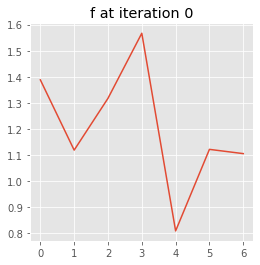

c:\users\jacob\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log


[-12.77279 -12.39973 -12.45717 -32.23420 -12.17732] [-12.76260 -12.39074 -12.44949 -32.15944 -12.16577]
tf.Tensor(-93.60383, shape=(), dtype=float32) tf.Tensor(-98.67232, shape=(), dtype=float32)


c:\users\jacob\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: overflow encountered in exp


[-12.56550 -12.43323 -12.15705 -34.60265 -11.96171] [-12.56916 -12.43306 -12.14050 -34.51381 -11.95611]
tf.Tensor(-91.72173, shape=(), dtype=float32) tf.Tensor(-95.17525, shape=(), dtype=float32)
[-14.68683 -12.54036 -12.02003 -34.75918 -12.20385] [-14.68280 -12.51874 -11.99746 -34.72680 -12.18763]
tf.Tensor(-99.73269, shape=(), dtype=float32) tf.Tensor(-94.11502, shape=(), dtype=float32)
[-17.07282 -12.50011 -11.87530 -35.16228 -12.17017] [-17.06375 -12.49076 -11.87747 -35.22737 -12.16954]
tf.Tensor(-100.527664, shape=(), dtype=float32) tf.Tensor(-96.83048, shape=(), dtype=float32)
[-17.58536 -12.47556 -12.65443 -34.94033 -12.20631] [-17.56577 -12.46309 -12.65578 -34.91870 -12.19691]
tf.Tensor(-97.27834, shape=(), dtype=float32) tf.Tensor(-97.80185, shape=(), dtype=float32)
[-19.58482 -12.56939 -12.88524 -35.01229 -12.17429] [-19.57898 -12.56656 -12.88702 -35.02326 -12.17311]
tf.Tensor(-97.82651, shape=(), dtype=float32) tf.Tensor(-99.64528, shape=(), dtype=float32)
[-21.44709 -13.367

[-152.00388 -36.36161 -16.11639 -300.87436 -48.04486] [-152.01199 -36.32500 -16.11537 -300.67477 -48.03820]
tf.Tensor(-565.0519, shape=(), dtype=float32) tf.Tensor(-559.65436, shape=(), dtype=float32)
[-151.98891 -36.36038 -16.60500 -299.90707 -66.69247] [-151.99141 -36.27909 -16.60992 -299.45001 -66.68595]
tf.Tensor(-582.00323, shape=(), dtype=float32) tf.Tensor(-577.5054, shape=(), dtype=float32)
[-151.99492 -36.23528 -16.67510 -325.44809 -66.65556] [-151.98465 -36.23233 -16.65929 -325.46646 -66.66843]
tf.Tensor(-607.6079, shape=(), dtype=float32) tf.Tensor(-603.5002, shape=(), dtype=float32)
[-152.02077 -36.46035 -16.67810 -324.97787 -95.17801] [-152.03017 -36.36819 -16.67165 -324.96674 -95.16718]
tf.Tensor(-631.6725, shape=(), dtype=float32) tf.Tensor(-631.69293, shape=(), dtype=float32)
[-152.04826 -36.43314 -15.91687 -325.41776 -82.14133] [-152.02696 -36.53924 -15.90961 -325.55307 -82.15666]
tf.Tensor(-622.29456, shape=(), dtype=float32) tf.Tensor(-618.5429, shape=(), dtype=float

KeyboardInterrupt: 

In [157]:
print('----- Metropolis Begins -----')
clear_params = False
if params is None or clear_params:
    params = {'δ': list(), 
              'k': [list() for _ in range(num_genes)],
              'σ': [list() for _ in range(num_genes)],
              'w': [list() for _ in range(num_genes)],
              'L': list(),
              'V': list()
             }
T = 2000

for iteration_number in range(T):
    if iteration_number % 50 == 0:
        print(f'{100*iteration_number/T:.2f}% complete', end='\r')
        print('k', np.exp(kbar_i))
    if iteration_number % 500 == 0:
        f_plot = np.exp(fbar_i)
        f_plot = [f_plot[i*num_disc+i] for i in range(N_m)]
        plt.figure(figsize=(4, 4))
        plt.plot(f_plot)
        plt.title(f'f at iteration {iteration_number}')
        plt.show()

    old_m_likelihood = m_likelihood()
    
    # Untransformed tf mRNA vectors F
    sample_tf_vectors()

    # Log of translation ODE degradation rates
    sample_translation_rates()
    
    # Log of transcription ODE kinetic params
    sample_transcription_rates()
    
    # Interaction weights and biases
    sample_interactions()

    # Noise variances (this doesn't use a loop over j, TODO: change other subroutines to similar)
    sample_noise()
    
    # Length scales and variances of GP kernels
    sample_rbf_params()
print('----- Finished -----')


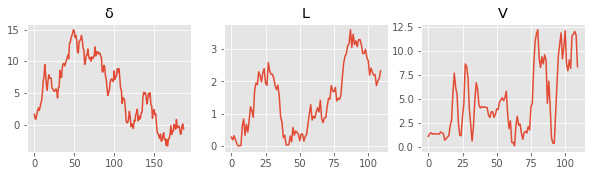

In [220]:
# Plot decay
plt.figure(figsize=(10, 8))
for i, param in enumerate(['δ', 'L', 'V']):
    ax = plt.subplot(331+i)
    plt.plot(params[param])
    ax.set_title(param)
#'σ', 'w']):


(171, 4)
(165, 4)
(175, 4)
(173, 4)
(181, 4)


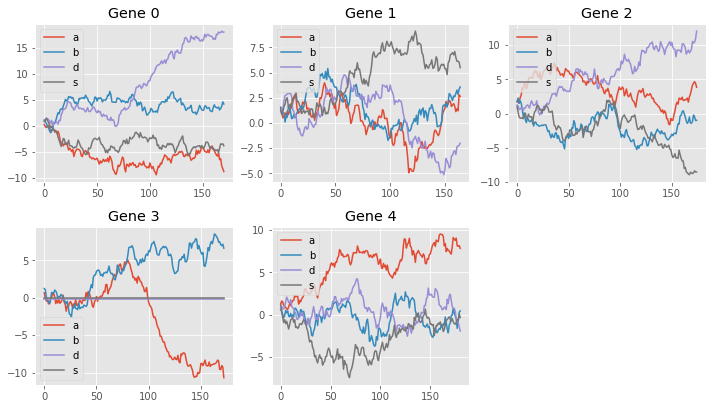

In [217]:
# Plot transcription ODE kinetic params
plt.figure(figsize=(10, 14))
plt.title('Transcription ODE kinetic parameters')
labels = ['a', 'b', 'd', 's']
for j in range(num_genes):
    ax = plt.subplot(num_genes, num_genes-2, j+1)
    k_param = np.array(params['k'][j])
    print(k_param.shape)
    
    for k in range(4):
        plt.plot(k_param[:, k], label=labels[k])
    plt.legend()
    ax.set_title(f'Gene {j}')

plt.tight_layout()


c:\users\jacob\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log


(5, 67)


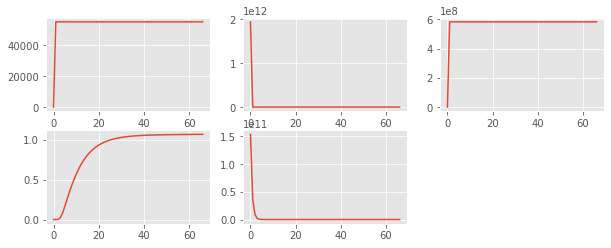

In [248]:
# Plot genes
plt.figure(figsize=(10, 10))
m_pred = predict_m(kbar_i, δbar_i, w_j, fbar_i)
print(m_pred.shape)
for j in range(num_genes):
    plt.subplot(531+j)
    plt.plot(m_pred[j, :])

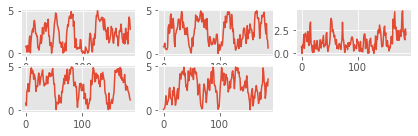

In [218]:
plt.figure(figsize=(7, 5))
plt.title('Noise variances')
for i, j in enumerate(range(num_genes)):
    ax = plt.subplot(num_genes, num_genes-2, i+1)
    plt.plot(params['σ'][j]);

[2.0028222, 6.4130516, 0.6762577, 0.61018914, 0.41234776, 0.8700391, 0.09759313]


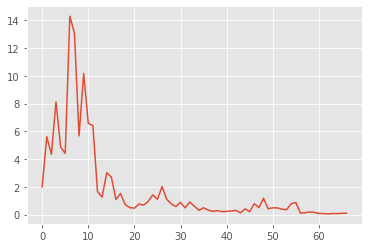

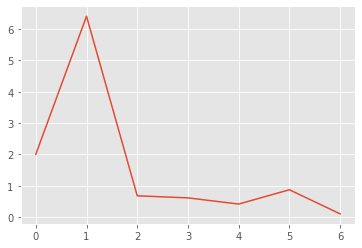

In [249]:
f_i = np.exp(fbar_i)
plt.plot(f_i)
plt.figure()
f_i = [f_i[i*num_disc+i] for i in range(N_m)]
print(f_i)
plt.plot(f_i)


In [ ]:
def get_rbf_dist(times, N):
    t_1 = np.reshape(np.tile(times, N), [N, N]).T
    t_2 = np.reshape(np.tile(times, N), [N, N])
    return t_1-t_2

def fbar_prior_params(v=v_i, l2=l2_i):
    t_dist = get_rbf_dist(τ, N_p)
#     print('vl2', v, l2)
    jitter = tf.linalg.diag(1e-5 * np.ones(N_p, dtype='float32'))
    K = v * np.exp(-np.square(t_dist)/(2*l2)) + jitter
#     print(K)
    m = np.zeros(N_p, dtype='float32')
    return m, K

# Likelihoods
def G(k, n, p_i, d_j, w):
    '''TF Activation Function'''
    # TODO add binary vector x_j for prior network knowledge (pg.3)
    numerator = np.exp(-d_j*(τ[n]-τ[k]))
    denominator = (1+np.exp(-w_j0-sum([w[:,i]*np.log(p_i[k]) for i in range(I)])))
    return numerator/denominator

def predict_m(kbar, δbar, w, fbar):
    # Take relevant parameters out of log-space
    a_j, b_j, d_j, s_j = (np.exp(kbar[:, i]) for i in range(4)) 
    δ = np.exp(δbar)
    f_i = np.log(1+np.exp(fbar))

    # Define p_i vector
    p_i = np.zeros(N_p)
    for n in range(N_p): # TODO it seems the ODE translation model has params A, S see gpmtfComputeTFODE
        N_pn = n#n*10+n
        p_i[n] = np.trapz([f_i[k] * np.exp(-δ*(τ[n]-τ[k])) for k in range(N_pn)], τ[:N_pn])
#     print('pi', p_i)

    # Calculate m_pred
    m_pred = np.zeros((num_genes, N_p), dtype='float32')

    for n in range(N_p):
        N_pn = n#*10+n
        ys =  np.array([G(k, n, p_i, d_j, w) for k in range(N_pn)])
        if ys.shape[0] == 0:
            ys = np.zeros((0, num_genes))
        integrals = np.array([np.trapz(ys[:, i], τ[:N_pn]) for i in range(num_genes)])
#         print('integrals', integrals)
#         print( np.exp(-d_j*t[n]))
        m_pred[:, n] = b_j/d_j + (a_j-b_j/d_j)* np.exp(-d_j*τ[n]) + s_j*integrals
    return m_pred

class RNA(gpflow.likelihoods.Likelihood):
    @params_as_tensors
    def variational_expectations(self, Fmu, Fvar, m_observed):
        
def m_likelihood(δbar=δbar_i, 
                 fbar=fbar_i, 
                 kbar=kbar_i, 
                 w=w_j,
                 σ_m2=σ_m2,
                 changed=True):
    
    m_pred = predict_m(kbar, δbar, w, fbar)
    lik = np.zeros(num_genes)
    diff = m_observed - m_pred[:, common_indices]
    t_dist = get_rbf_dist(t, N_m)        # RBF covariance
    jitter = tf.linalg.diag(1e-5 * np.ones(N_m, dtype='float32'))
    K = 1 * np.exp(-np.square(t_dist)/(2*1)) + jitter # TODO replace v, l2
    for j in range(num_genes):
        K_j = K + tf.linalg.diag(σ2[j])
#         print(K_j)
        L = tf.linalg.cholesky(K_j)
        d = diff[j][:, None]
        alpha = tf.linalg.triangular_solve(L, d, lower=True)
        num_dims = tf.cast(tf.shape(d)[0], L.dtype)
        p = -0.5 * tf.reduce_sum(tf.square(alpha), 0)
        p -= 0.5 * num_dims * np.log(2 * np.pi)
        p -= tf.reduce_sum(tf.math.log(tf.linalg.diag_part(L)))
        lik[j] = p
    return lik

def f_likelihood(fbar, i=0): 
    '''TODO this should be for the i-th TF'''
    f_i = np.log(1+np.exp(fbar))
    f_i = np.float32(np.atleast_2d(f_i[common_indices]))
#     print(f_i[i], f[i])
    prob = tfd.Normal(f_observed[i], σ2_f[i]).log_prob(f_i[i])
#     print('prob', prob)
    lik = tf.reduce_sum(prob)
    return lik


In [252]:
kernel = gpflow.kernels.RBF() + gpflow.kernels.White(variance=0.01)

model = gpflow.models.SGPMC(
    data,
    kernel=kernel,
    likelihood=gpflow.likelihoods.MultiClass(3),
    inducing_variable=X[::5].copy(),
    num_latent_gps=3,
)
model.kernel.kernels[0].variance.prior = tfd.Gamma(f64(1.0), f64(1.0))
model.kernel.kernels[0].lengthscales.prior = tfd.Gamma(f64(2.0), f64(2.0))
set_trainable(model.kernel.kernels[1].variance, False)

gpflow.utilities

NameError: name 'data' is not defined